In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
import pytz
import glob
import os
import re
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Prepare the Dataset for Unsupervised Learning

In [3]:
nfl_games_juice_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\sportsbook_data_ALL_with_Juice.csv'
nfl_games_juice_df = pd.read_csv(nfl_games_juice_file)

C:\Users\benny\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5,6,7,9,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Create a Time Label in Hours from the Odds Timestamp

In [29]:
game_time_str = nfl_games_juice_df.loc[:,'Game Time']
game_time_str = game_time_str.str.slice(0,19)
timestamp_str = nfl_games_juice_df.loc[:,'timestamp_est']
timestamp_str = timestamp_str.str.slice(0,19)

print(game_time_str)
print(timestamp_str)


0         2018-09-06 20:20:00
1         2018-09-06 20:20:00
2         2018-09-06 20:20:00
3         2018-09-06 20:20:00
4         2018-09-06 20:20:00
5         2018-09-06 20:20:00
6         2018-09-06 20:20:00
7         2018-09-06 20:20:00
8         2018-09-06 20:20:00
9         2018-09-06 20:20:00
10        2018-09-06 20:20:00
11        2018-09-06 20:20:00
12        2018-09-06 20:20:00
13        2018-09-06 20:20:00
14        2018-09-06 20:20:00
15        2018-09-06 20:20:00
16        2018-09-06 20:20:00
17        2018-09-06 20:20:00
18        2018-09-06 20:20:00
19        2018-09-06 20:20:00
20        2018-09-06 20:20:00
21        2018-09-06 20:20:00
22        2018-09-06 20:20:00
23        2018-09-06 20:20:00
24        2018-09-06 20:20:00
25        2018-09-06 20:20:00
26        2018-09-06 20:20:00
27        2018-09-06 20:20:00
28        2018-09-06 20:20:00
29        2018-09-06 20:20:00
                 ...         
418678    2018-12-30 16:25:00
418679    2018-12-30 16:25:00
418680    

In [32]:
game_time_date = pd.to_datetime(game_time_str, format='%Y-%m-%d %H:%M:%S')
timestamp_date = pd.to_datetime(timestamp_str, format='%Y-%m-%d %H:%M:%S')
print(game_time_date)
print(timestamp_date)

0        2018-09-06 20:20:00
1        2018-09-06 20:20:00
2        2018-09-06 20:20:00
3        2018-09-06 20:20:00
4        2018-09-06 20:20:00
5        2018-09-06 20:20:00
6        2018-09-06 20:20:00
7        2018-09-06 20:20:00
8        2018-09-06 20:20:00
9        2018-09-06 20:20:00
10       2018-09-06 20:20:00
11       2018-09-06 20:20:00
12       2018-09-06 20:20:00
13       2018-09-06 20:20:00
14       2018-09-06 20:20:00
15       2018-09-06 20:20:00
16       2018-09-06 20:20:00
17       2018-09-06 20:20:00
18       2018-09-06 20:20:00
19       2018-09-06 20:20:00
20       2018-09-06 20:20:00
21       2018-09-06 20:20:00
22       2018-09-06 20:20:00
23       2018-09-06 20:20:00
24       2018-09-06 20:20:00
25       2018-09-06 20:20:00
26       2018-09-06 20:20:00
27       2018-09-06 20:20:00
28       2018-09-06 20:20:00
29       2018-09-06 20:20:00
                 ...        
418678   2018-12-30 16:25:00
418679   2018-12-30 16:25:00
418680   2018-12-30 16:25:00
418681   2018-

In [38]:
diff = (game_time_date - timestamp_date).astype('timedelta64[h]')
print(diff)
nfl_games_juice_df['Hours To Game'] = diff

0         104.0
1         171.0
2         170.0
3         169.0
4         168.0
5         167.0
6         154.0
7         153.0
8         152.0
9         151.0
10        150.0
11        149.0
12        148.0
13        147.0
14        146.0
15        145.0
16        144.0
17        143.0
18        142.0
19        141.0
20        140.0
21        139.0
22        138.0
23        137.0
24        136.0
25        135.0
26        134.0
27        133.0
28        132.0
29        131.0
          ...  
418678     28.0
418679     27.0
418680     26.0
418681     25.0
418682     24.0
418683     23.0
418684     22.0
418685     21.0
418686     20.0
418687     19.0
418688     18.0
418689     17.0
418690     16.0
418691     15.0
418692     14.0
418693     13.0
418694     12.0
418695     11.0
418696     10.0
418697      9.0
418698      8.0
418699      7.0
418700      6.0
418701      5.0
418702      4.0
418703      3.0
418704      3.0
418705      2.0
418706      1.0
418707      0.0
Length: 418708, dtype: f

In [47]:
nfl_games_juice_hours_df = nfl_games_juice_df[['Book','Away Moneyline','Home Moneyline','Away Pointspread points','Away Pointspread odds','Home Pointspread points','Home Pointspread odds','Total points','Over odds','Under odds','Away_x','Home_x','Game','Game Number','timestamp_est','Winner/tie','Loser/tie','PtsW','PtsL','YdsW','TOW','YdsL','TOL','Home_y','Away_y','Game Time','Pre-Game','Juice Moneyline','Juice Pointspread','Juice Total','Hours To Game']]
print(nfl_games_juice_hours_df.head())

        Book Away Moneyline Home Moneyline Away Pointspread points  \
0   alfabook            115           -135                     2.5   
1  bravobook            NaN            NaN                       3   
2  bravobook            NaN            NaN                       3   
3  bravobook            NaN            NaN                       3   
4  bravobook            NaN            NaN                       3   

   Away Pointspread odds Home Pointspread points  Home Pointspread odds  \
0                 -110.0                    -2.5                 -110.0   
1                 -119.0                      -3                 -101.0   
2                 -110.0                      -3                 -110.0   
3                 -110.0                      -3                 -110.0   
4                 -110.0                      -3                 -110.0   

   Total points  Over odds  Under odds      ...       YdsL TOL  \
0          45.5     -108.0      -112.0      ...        299   1

In [48]:
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
nfl_games_juice_hours_df.to_csv(export_path+"\\sportsbook_data_ALL_with_Juice_Hours.csv",index=False)

In [3]:
nfl_games_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\sportsbook_data_ALL_with_Juice_Hours.csv'
nfl_games_df = pd.read_csv(nfl_games_file)

C:\Users\benny\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2,3,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
nfl_games_df["Book"] = nfl_games_df["Book"].astype('category')
nfl_games_df["Book Encoded"] = nfl_games_df["Book"].cat.codes
nfl_games_df.reset_index(drop=True, inplace=True)
print(nfl_games_df.head())

   Unnamed: 0       Book Away Moneyline Home Moneyline  \
0           0   alfabook            115           -135   
1           1  bravobook            NaN            NaN   
2           2  bravobook            NaN            NaN   
3           3  bravobook            NaN            NaN   
4           4  bravobook            NaN            NaN   

  Away Pointspread points  Away Pointspread odds Home Pointspread points  \
0                     2.5                 -110.0                    -2.5   
1                       3                 -119.0                      -3   
2                       3                 -110.0                      -3   
3                       3                 -110.0                      -3   
4                       3                 -110.0                      -3   

   Home Pointspread odds  Total points  Over odds      ...       TOL  \
0                 -110.0          45.5     -108.0      ...         1   
1                 -101.0          45.5     -105.0 

# Create Time Series with 120 Hours of Odds into the Game

In [5]:
nfl_games_120_df = nfl_games_df[(nfl_games_df['Hours To Game']<120) & (nfl_games_df['Hours To Game']>=0)]
print(nfl_games_df.shape)
print(nfl_games_120_df.shape)

(418708, 33)
(192815, 33)


In [6]:
nfl_games_120_df = nfl_games_120_df[['Book','Away Moneyline','Home Moneyline','Away Pointspread odds','Home Pointspread odds','Over odds','Under odds','Game Number','Hours To Game','Book Encoded']]
#nfl_games_24_df = nfl_games_24_df[['Book','Away Moneyline','Home Moneyline','Away Pointspread odds','Home Pointspread odds','Over odds','Under odds','Game Number','Hours To Game']]
print(nfl_games_120_df.shape)

(192815, 10)


In [7]:
sportsbook_ids = [s for s in range(0, 12)]
game_ids = [i for i in range(1, 177)]
hours_ids = [z for z in range(119,-1,-1)]
print(sportsbook_ids)
print(game_ids)
print(hours_ids)
print(nfl_games_120_df.dtypes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176]
[119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78,

In [11]:
away_moneyline_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Away Moneyline']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            away_moneyline_time_series.append(odds_series)


In [12]:
away_moneyline_time_series_df = pd.DataFrame(away_moneyline_time_series)
print(away_moneyline_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
away_moneyline_time_series_df.to_csv(export_path+"\\away_moneyline_time_series_120_df.csv",index=False)

(1775, 122)


In [14]:
home_moneyline_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Home Moneyline']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            home_moneyline_time_series.append(odds_series)

In [15]:
home_moneyline_time_series_df = pd.DataFrame(home_moneyline_time_series)
print(home_moneyline_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
home_moneyline_time_series_df.to_csv(export_path+"\\home_moneyline_time_series_120_df.csv",index=False)

(1775, 122)


In [17]:
away_pointspread_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Away Pointspread odds']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            away_pointspread_time_series.append(odds_series)

In [18]:
away_pointspread_time_series_df = pd.DataFrame(away_pointspread_time_series)
print(away_pointspread_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
away_pointspread_time_series_df.to_csv(export_path+"\\away_pointspread_time_series_120_df.csv",index=False)

(1775, 122)


In [19]:
home_pointspread_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Home Pointspread odds']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            home_pointspread_time_series.append(odds_series)

In [20]:
home_pointspread_time_series_df = pd.DataFrame(home_pointspread_time_series)
print(home_pointspread_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
home_pointspread_time_series_df.to_csv(export_path+"\\home_pointspread_time_series_120_df.csv",index=False)

(1775, 122)


In [21]:
over_odds_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Over odds']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            over_odds_time_series.append(odds_series)

In [22]:
over_odds_time_series_df = pd.DataFrame(over_odds_time_series)
print(over_odds_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
over_odds_time_series_df.to_csv(export_path+"\\over_odds_time_series_120_df.csv",index=False)

(1775, 122)


In [23]:
under_odds_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Under odds']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            under_odds_time_series.append(odds_series)

In [24]:
under_odds_time_series_df = pd.DataFrame(under_odds_time_series)
print(under_odds_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
under_odds_time_series_df.to_csv(export_path+"\\under_odds_time_series_120_df.csv",index=False)

(1775, 122)


# Data Imputation to Fill in the Data Gaps

In [114]:
home_pointspread_data = pd.read_csv (r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\home_pointspread_time_series_120_df.csv')
away_pointspread_data = pd.read_csv (r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\away_pointspread_time_series_120_df.csv')
under_odds_data = pd.read_csv (r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\under_odds_time_series_120_df.csv')
over_odds_data = pd.read_csv (r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\over_odds_time_series_120_df.csv')
home_moneyline_data = pd.read_csv (r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\home_moneyline_time_series_120_df.csv')
away_moneyline_data = pd.read_csv (r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\away_moneyline_time_series_120_df.csv')


print(home_moneyline_data.shape)
na_num = 60
#pointspread_data = home_pointspread_data.append(away_pointspread_data, ignore_index=True)
#total_points_data = over_odds_data.append(under_odds_data, ignore_index=True)
#moneyline_data = home_moneyline_data.append(away_moneyline_data, ignore_index=True)
#moneyline_data = home_moneyline_data
#print(len(pointspread_data.index))
#print(len(total_points_data.index))
#print(len(moneyline_data.index))
#pointspread_data.dropna(thresh=na_num,inplace=True)
#total_points_data.dropna(thresh=na_num,inplace=True)
home_moneyline_data.dropna(thresh=na_num,inplace=True)
home_moneyline_data.reset_index()
away_moneyline_data.dropna(thresh=na_num,inplace=True)
away_moneyline_data.reset_index()
#print(len(pointspread_data.index))
#print(len(total_points_data.index))
#print(len(moneyline_data.index))


(1775, 122)


,index,0,1,2,3,4,5,6,7,8,...,112,113,114,115,116,117,118,119,120,121
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,1,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,...,NaN,-104.0,NaN,NaN,NaN,-115.0,NaN,NaN,1,1
2,2,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,...,-120.0,-120.0,-120.0,-120.0,-115.0,-115.0,-120.0,-120.0,1,2
3,3,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,...,-111.0,-105.0,-111.0,-111.0,-111.0,-111.0,-105.0,-111.0,1,3
4,4,115.0,115.0,115.0,115.0,115.0,115.0,115.0,115.0,115.0,...,-117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4
5,5,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,...,NaN,-104.0,NaN,NaN,NaN,-116.0,NaN,-115.0,1,6
6,6,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,...,-115.0,-105.0,-110.0,-110.0,-110.0,-110.0,-110.0,-115.0,1,7
7,7,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,...,-120.0,-125.0,-120.0,-120.0,-120.0,-120.0,-120.0,-120.0,1,8
8,8,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,...,-120.0,-125.0,-120.0,-120.0,-120.0,-120.0,-120.0,-120.0,1,9
9,9,115.0,115.0,115.0,115.0,115.0,115.0,115.0,115.0,115.0,...,-110.0,-107.0,-110.0,-110.0,-110.0,-110.0,NaN,NaN,1,10


In [115]:
#impute missing values 
#pointspread_data.fillna(method='bfill', inplace=True)
#total_points_data.fillna(method='bfill', inplace=True)
home_moneyline = home_moneyline_data.iloc[:,0:120]
away_moneyline = away_moneyline_data.iloc[:,0:120]
home_moneyline.fillna(axis=1,method='bfill', inplace=True)
away_moneyline.fillna(axis=1,method='bfill', inplace=True)
home_moneyline.fillna(axis=1,method='ffill', inplace=True)
away_moneyline.fillna(axis=1,method='ffill', inplace=True)

home_moneyline_data = pd.concat([home_moneyline,home_moneyline_data['120'],home_moneyline_data['121']],axis=1)
away_moneyline_data = pd.concat([away_moneyline,away_moneyline_data['120'],away_moneyline_data['121']],axis=1)

In [116]:
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
#total_points_data.to_csv(export_path+"\\total_points_120.csv")
#pointspread_data.to_csv(export_path+"\\pointspread_120.csv")
home_moneyline_data.to_csv(export_path+"\\home_moneyline_120.csv",index=False)
away_moneyline_data.to_csv(export_path+"\\away_moneyline_120.csv",index=False)

# Unsupervised Learning Implementation

In [78]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

## Moneyline (Home and Away)

In [79]:
home_moneyline_odds_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\home_moneyline_120.csv'
home_moneyline_odds_time_series_df = pd.read_csv(home_moneyline_odds_file)
home_moneyline_odds_clustering = home_moneyline_odds_time_series_df.iloc[:,0:120]
print(home_moneyline_odds_clustering.head())
#moneyline_odds_clustering = moneyline_odds_clustering.abs()
#print(moneyline_odds_clustering.head())
away_moneyline_odds_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\away_moneyline_120.csv'
away_moneyline_odds_time_series_df = pd.read_csv(away_moneyline_odds_file)
away_moneyline_odds_clustering = away_moneyline_odds_time_series_df.iloc[:,0:120]
print(away_moneyline_odds_clustering.head())

       0      1      2      3      4      5      6      7      8      9  \
0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0   
1 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0   
2 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0 -140.0   
3 -147.0 -147.0 -147.0 -147.0 -147.0 -147.0 -147.0 -147.0 -147.0 -147.0   
4 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0 -135.0   

   ...      110    111    112    113    114    115    116    117    118    119  
0  ...   -114.0 -102.0 -103.0 -103.0 -103.0 -103.0 -103.0 -103.0 -103.0 -103.0  
1  ...   -119.0 -105.0 -116.0 -116.0 -105.0 -105.0 -105.0 -105.0 -105.0 -105.0  
2  ...   -115.0  100.0  100.0  100.0  100.0  100.0 -105.0 -105.0  100.0  100.0  
3  ...   -120.0 -111.0 -111.0 -116.0 -111.0 -111.0 -111.0 -111.0 -116.0 -111.0  
4  ...   -114.0 -102.0 -103.0 -103.0 -103.0 -103.0 -103.0 -103.0 -103.0 -103.0  

[5 rows x 120 columns]
       0      1      2      3      4   

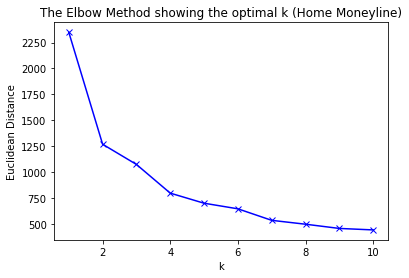

[2350.2105552975245, 1268.2876859806877, 1073.329444266274, 796.0793412875801, 698.6668495206392, 644.6052361987956, 533.3224761602233, 495.86116982357845, 455.12175839959514, 440.8009558333447]


In [80]:
# k means determine k
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(home_moneyline_odds_clustering)
    kmeanModel.fit(home_moneyline_odds_clustering)
    distortions.append(sum(np.min(cdist(home_moneyline_odds_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / home_moneyline_odds_clustering.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Euclidean Distance')
plt.title('The Elbow Method showing the optimal k (Home Moneyline)')
plt.show()

print(distortions)

## Function For Calculating the Distance from the Centroids 

In [81]:
def k_mean_distance(PCAx, PCAy, cx, cy):
    return np.sqrt((PCAx-cx)**2+(PCAy-cy)**2)

## Home Moneyline

In [82]:
kmeans = KMeans(n_clusters=5,random_state=3425).fit(home_moneyline_odds_clustering)
centroids = kmeans.cluster_centers_
#print(centroids)
c= kmeans.labels_.astype(int)

In [83]:
c_df = pd.DataFrame(c)
home_moneyline_odds_time_series_df['Cluster'] = c_df

In [84]:
# cluster_0_df = home_moneyline_odds_time_series_df[home_moneyline_odds_time_series_df['Cluster']==0]
# plt.figure(1)
# cluster_0_df['121'].value_counts().plot('bar')

# cluster_1_df = home_moneyline_odds_time_series_df[home_moneyline_odds_time_series_df['Cluster']==1]
# plt.figure(2)
# cluster_1_df['121'].value_counts().plot('bar')

# cluster_2_df = home_moneyline_odds_time_series_df[home_moneyline_odds_time_series_df['Cluster']==2]
# plt.figure(3)
# cluster_2_df['121'].value_counts().plot('bar')

# cluster_3_df = home_moneyline_odds_time_series_df[home_moneyline_odds_time_series_df['Cluster']==3]
# plt.figure(4)
# cluster_3_df['121'].value_counts().plot('bar')

#cluster_4_df = moneyline_odds_time_series_df[moneyline_odds_time_series_df['Cluster']==4]
#plt.figure(5)
#cluster_4_df['121'].value_counts().plot('bar')

#cluster_5_df = moneyline_odds_time_series_df[moneyline_odds_time_series_df['Cluster']==5]
#plt.figure(6)
#cluster_5_df['121'].value_counts().plot('bar')

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
home_moneyline_centers2D = pca.fit_transform(centroids)
principalComponents = pca.fit_transform(home_moneyline_odds_clustering)
home_moneyline_principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])


In [86]:
print(home_moneyline_principalDf.head())

          PC1         PC2
0  130.914137 -104.010984
1  144.314179 -107.892845
2  -32.514144 -302.662370
3  145.286761 -110.697980
4  130.914137 -104.010984


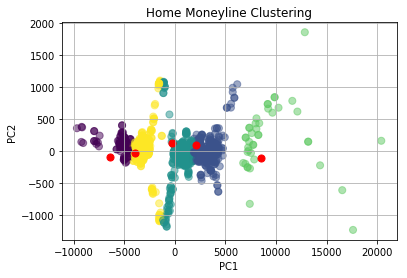

In [87]:
plt.scatter(home_moneyline_principalDf['PC1'], home_moneyline_principalDf['PC2'], c= kmeans.labels_.astype(int), s=50, alpha=0.5)
plt.scatter(home_moneyline_centers2D[:, 0], centers2D[:, 1], c='red', s=50)
plt.title('Home Moneyline Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

## Calculate Distances from the Centroids (Home Moneyline)

In [88]:
distances = []
for i in range(0,len(home_moneyline_principalDf)):
    mean_distance = k_mean_distance(home_moneyline_principalDf.iloc[i,0], home_moneyline_principalDf.iloc[i,1], home_moneyline_centers2D[c[i],0], home_moneyline_centers2D[c[i],1])
    distances.append(mean_distance)

distance_df = pd.DataFrame(distances)
print(distance_df.head())

            0
0  490.990591
1  504.620501
2  509.816216
3  506.810763
4  490.990591


In [89]:
home_moneyline_odds_time_series_df['Distance'] = distance_df

In [90]:
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
home_moneyline_odds_time_series_df.to_csv(export_path+"\\home_moneyline_cluster_120.csv",index=False)

## Find the Top 3 Outliers by Distance for Each Cluster (Home Moneyline)

In [117]:
home_moneyline_outliers = pd.DataFrame()
top = 3
for i in range(0,5):    
    home_moneyline_outliers = home_moneyline_outliers.append(home_moneyline_odds_time_series_df[home_moneyline_odds_time_series_df['Cluster']==i].nlargest(top, 'Distance'),ignore_index=True)

In [118]:
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
home_moneyline_outliers.to_csv(export_path+"\\home_moneyline_outliers_120.csv",index=False)

## Away Moneyline

In [119]:
kmeans = KMeans(n_clusters=5,random_state=3425).fit(away_moneyline_odds_clustering)
centroids = kmeans.cluster_centers_
#print(centroids)
c= kmeans.labels_.astype(int)

In [120]:
c_df = pd.DataFrame(c)
away_moneyline_odds_time_series_df['Cluster'] = c_df

In [122]:
# cluster_0_df = away_moneyline_odds_time_series_df[away_moneyline_odds_time_series_df['Cluster']==0]
# plt.figure(1)
# cluster_0_df['121'].value_counts().plot('bar')

# cluster_1_df = away_moneyline_odds_time_series_df[away_moneyline_odds_time_series_df['Cluster']==1]
# plt.figure(2)
# cluster_1_df['121'].value_counts().plot('bar')

# cluster_2_df = away_moneyline_odds_time_series_df[away_moneyline_odds_time_series_df['Cluster']==2]
# plt.figure(3)
# cluster_2_df['121'].value_counts().plot('bar')

# cluster_3_df = away_moneyline_odds_time_series_df[away_moneyline_odds_time_series_df['Cluster']==3]
# plt.figure(4)
# cluster_3_df['121'].value_counts().plot('bar')

In [123]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
away_moneyline_centers2D = pca.fit_transform(centroids)
principalComponents = pca.fit_transform(away_moneyline_odds_clustering)
away_moneyline_principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

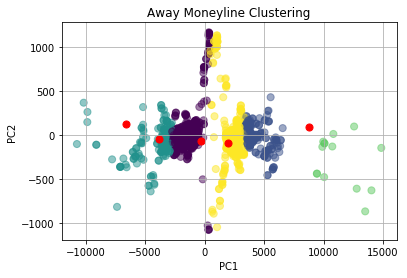

In [124]:
plt.scatter(away_moneyline_principalDf['PC1'], away_moneyline_principalDf['PC2'], c= kmeans.labels_.astype(int), s=50, alpha=0.5)
plt.scatter(away_moneyline_centers2D[:, 0], away_moneyline_centers2D[:, 1], c='red', s=50)
plt.title('Away Moneyline Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

## Calculate Distances from the Centroids (Away Moneyline)

In [125]:
distances = []
for i in range(0,len(away_moneyline_principalDf)):
    mean_distance = k_mean_distance(away_moneyline_principalDf.iloc[i,0], away_moneyline_principalDf.iloc[i,1], away_moneyline_centers2D[c[i],0], away_moneyline_centers2D[c[i],1])
    distances.append(mean_distance)

distance_df = pd.DataFrame(distances)
print(distance_df.head())

             0
0  3914.357989
1  3902.264599
2  3944.696438
3  3842.713030
4  3914.357989


In [126]:
away_moneyline_odds_time_series_df['Distance'] = distance_df

In [127]:
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
away_moneyline_odds_time_series_df.to_csv(export_path+"\\away_moneyline_cluster_120.csv",index=False)

## Find the Top 3 Outliers by Distance for Each Cluster (Away Moneyline)

In [128]:
away_moneyline_outliers = pd.DataFrame()
top = 3
for i in range(0,5):    
    away_moneyline_outliers = away_moneyline_outliers.append(away_moneyline_odds_time_series_df[away_moneyline_odds_time_series_df['Cluster']==i].nlargest(top, 'Distance'),ignore_index=True)

In [129]:
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
away_moneyline_outliers.to_csv(export_path+"\\away_moneyline_outliers_120.csv",index=False)

## Plot the Histogram of the Mean Odds for Moneyline by Clusters

Text(0.5, 1.0, 'Distribution of Mean Away Moneyline Odds by Clusters')

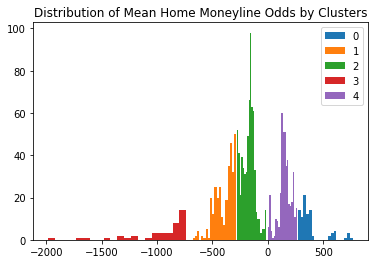

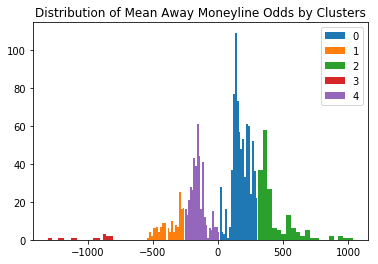

In [130]:
away_moneyline_cluster_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\away_moneyline_cluster_120.csv'
home_moneyline_cluster_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\home_moneyline_cluster_120.csv'
away_moneyline_time_series_cluster_df = pd.read_csv(away_moneyline_cluster_file)
home_moneyline_time_series_cluster_df = pd.read_csv(home_moneyline_cluster_file)

l = []
for i in range(0,5):
    home_moneyline_cluster = home_moneyline_time_series_cluster_df[home_moneyline_time_series_cluster_df['Cluster']==i]
    home_moneyline_cluster = home_moneyline_cluster.iloc[:,0:120]
    #print(home_moneyline_cluster['120'].unique())
    home_cluster = home_moneyline_cluster.mean(axis=1)
    plt.figure(1)
    plt.hist(home_cluster,bins=20)
    l.append(i)
    plt.legend(l)
plt.title('Distribution of Mean Home Moneyline Odds by Clusters')

l = []
for i in range(0,5):
    away_moneyline_cluster = away_moneyline_time_series_cluster_df[away_moneyline_time_series_cluster_df['Cluster']==i]
    away_moneyline_cluster = away_moneyline_cluster.iloc[:,0:120]
    #print(away_moneyline_cluster['120'].unique())
    away_cluster = away_moneyline_cluster.mean(axis=1)
    plt.figure(2)
    plt.hist(away_cluster,bins=20)
    l.append(i)
    plt.legend(l)
plt.title('Distribution of Mean Away Moneyline Odds by Clusters')


In [131]:
grouped_home_moneyline = home_moneyline_time_series_cluster_df.groupby('Cluster')
grouped_away_moneyline = away_moneyline_time_series_cluster_df.groupby('Cluster')
x = grouped_home_moneyline['120'].unique()
y = grouped_away_moneyline['120'].unique()
x_df = pd.DataFrame(x)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
x_df.to_csv(export_path+"\\home_moneyline_cluster_games.csv",index=False)
y = grouped_away_moneyline['120'].unique()
y_df = pd.DataFrame(y)
y_df.to_csv(export_path+"\\away_moneyline_cluster_games.csv",index=False)